In [1]:
#imports
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import matplotlib as mpl
import astropy.coordinates as coord
import seaborn as sns
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {#'family' : 'Helvetica',
        'size'   : 16}

In [2]:
path_plot = '/users/caganze/research/stellarstreams/figures/streamssims/'
path_data = '/users/caganze/research/stellarstreams/data/'
_ = coord.galactocentric_frame_defaults.set('v4.0')
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

In [76]:
def generate_stream_and_perturber(mass, prog_w0, timedict,  nbody=None, output_every=None,
                                  output_filename=None):
    """
    Input: mass of the progenitor, its position, other mockstream generator kwrargs
    Returns: final stream and its position and velocity
    
    Calls mockstream generator
    
    """
    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
    gen = ms.MockStreamGenerator(df, H)

    return gen.run(prog_w0, prog_mass, nbody=nbody,\
                   output_every=output_every, output_filename= output_filename, \
                check_filesize=True, overwrite=True, n_particles=5,  progress=True, **timedict)

def run_stream_and_subhalo(halo_mass, stream_mass, halo_r, halo_pos, stream_pos, timedict,
                           filename='mockstream',
                            output_every=1, potential_type='plummer'):
    """
    runs a subhalo and a stream 
    
    returns the progenitor position and the final stream
    
    Takes in the parameters of the subhalos
    
    """
    
    #create a plummer sphere 
    point_potential=gp.PlummerPotential(halo_mass*u.Msun,  halo_r, units=galactic)
    
    #if potential_type
    if  potential_type.lower()=='hernquist':
        point_potential=gp.HernquistPotential(halo_mass*u.Msun,  halo_r, units=galactic)
        
    #create an Nbody potential object
    Massive_body=gd.DirectNBody(halo_pos, [point_potential], external_potential=pot)
    
    return  generate_stream_and_perturber(stream_mass,  stream_pos, timedict, \
                                      nbody=Massive_body,
                                    output_every=output_every, \
                                    output_filename=path_data+'/'+filename+'.h5')

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    return body, stream_cont

def plot_stream_and_body(idx, stream_cont, body, time_dict, \
                        xlim=[-5, 5], ylim=[-5, 5], zlim=[-5, 5]):
    
    body_pos=body['pos']
    stream_pos=stream_cont['pos']
    
    stream_vel=stream_cont['vel']
    stream_velz=(stream_vel[-1][idx]*u.kpc/u.Myr).to(u.km/u.s).value
    #stream_velz= stream_velz)
    
    if 't' in time_dict.keys():
        t=time_dict['t'][idx]
    else:
        t= time_dict['tmin']+20*idx*time_dict['dt']
    t=t.to(u.Myr)
    
    fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)
    
    fig.suptitle('T = {}  Timesetep = {}'.format(t,idx ), fontsize=16)

    
    ax.scatter(stream_pos[0][idx], stream_pos[1][idx], s=1, alpha=0.5, \
               c= stream_velz, label='Stream',  cmap='cubehelix')
    
    ax.scatter(body_pos[0][idx], body_pos[1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    
    ax1.scatter(stream_pos[0][idx], stream_pos[-1][idx],  s=1, alpha=0.5, \
                c= stream_velz,\
                label='Stream',  cmap='cubehelix')
    ax1.scatter(body_pos[0][idx], body_pos[-1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    c=ax2.scatter(stream_pos[1][idx], stream_pos[-1][idx],  s=1, alpha=0.5,  \
                c=stream_velz,\
                label='Stream', cmap='cubehelix')
    ax2.scatter(body_pos[1][idx], body_pos[-1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
   
    

    ax.minorticks_on()
    ax1.minorticks_on()

    #ax1.legend(fontsize=14)
    ax.set(xlabel='x (pc)', ylabel='y (pc)')
    ax1.set(xlabel='x (pc)', ylabel='z (pc)')
    ax2.set(xlabel=r'y (pc)', ylabel='z (pc)')
    
    cbar= plt.colorbar(c)
    cbar.ax.set(ylabel='Normalized Vz')
    
    #ax.set(xlim=xlim, ylim=ylim)
    #ax1.set(xlim=xlim, ylim=zlim)
    #ax2.set(xlim=ylim, ylim=zlim)
    
    plt.tight_layout()
    
    
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    


    return image

In [4]:
#satellite position
st_pos = gd.PhaseSpacePosition(pos=[12., 0., 50.] * u.kpc,
                                vel=[0, 170, 0.] * u.km/u.s) #at andromeda
mstream=5e5
mhalo=1e8
halo_r=20*u.pc
tintegrate=700 #in myr
tmax=1000 #in myr
tfinal=1200 #in myr
tmin=0.
nsteps=300
filename='andromeda_stream_test'


In [5]:
#call mockstream generator
time_dict_stream={'t': np.linspace(tmin, tintegrate, nsteps)*u.Myr}
df = ms.FardalStreamDF()
prog_mass = mstream* u.Msun
gen = ms.MockStreamGenerator(df, H)
mock_st, mock_pos=gen.run(st_pos, prog_mass, **time_dict_stream, nbody=None, n_particles=5, progress=True)

Integrating orbits:  100%

/opt/anaconda3/lib/python3.8/site-packages/astropy/coordinates/baseframe.py:1207: AstropyDeprecationWarning: Transforming a frame instance to a frame class (as opposed to another frame instance) will not be supported in the future.  Either explicitly instantiate the target frame, or first convert the source frame instance to a `astropy.coordinates.SkyCoord` and use its `transform_to()` method.
  warnings.warn("Transforming a frame instance to a frame class (as opposed to another "



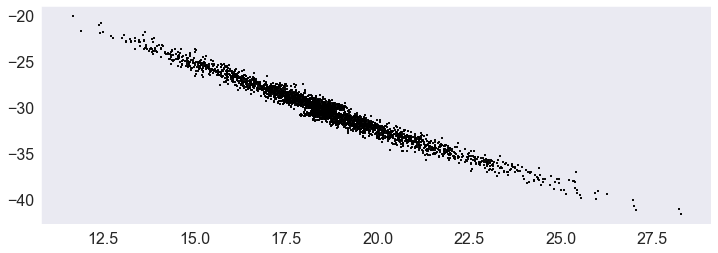

In [6]:
moc_icrs= mock_st.to_coord_frame(coord.ICRS)#.plot(s=1, c='k')
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(moc_icrs.ra, moc_icrs.dec, s=1, c='k', marker=',')

In [7]:
 time_dict= {'t':np.linspace(0, tmax, int(nsteps*5))*u.Myr}

In [8]:
#pick a position to send a stream through

In [9]:
#put a random position
col_idx= np.random.choice(len(mock_st.z))
collision_pos=mock_st.xyz[:, col_idx]


In [10]:
#col_idx

In [11]:
collision_phase_space_pos=gd.PhaseSpacePosition(pos=collision_pos,
                                vel=[0, 0, -500] * u.km/u.s)
#integrate it back
collision_orbit= gp.Hamiltonian(pot).integrate_orbit(collision_phase_space_pos,  dt=-1*u.Myr,\
                                                     t1=0.*u.Myr, t2=-tintegrate*u.Myr)

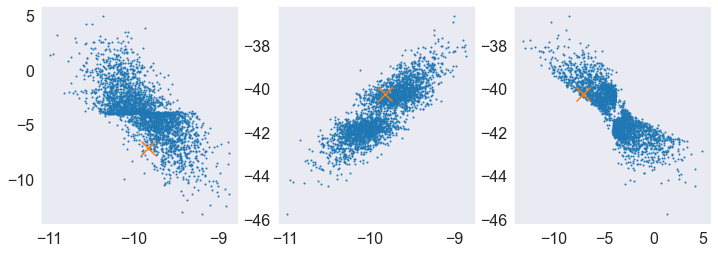

In [12]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(mock_st.cartesian.x,mock_st.cartesian.y, s=1)
ax[1].scatter(mock_st.cartesian.x, mock_st.cartesian.z, s=1)
ax[2].scatter(mock_st.cartesian.y, mock_st.cartesian.z, s=1)

ax[0].scatter(collision_phase_space_pos.x, collision_phase_space_pos.y, s=200, marker='x')
ax[1].scatter(collision_phase_space_pos.x, collision_phase_space_pos.z, s=200, marker='x')
ax[2].scatter(collision_phase_space_pos.y, collision_phase_space_pos.z, s=200, marker='x')

In [13]:
time_dict

{'t': <Quantity [0.00000000e+00, 6.67111408e-01, 1.33422282e+00, ...,
            9.98665777e+02, 9.99332889e+02, 1.00000000e+03] Myr>}

In [14]:
#hbjk

In [15]:
#create this as the halo orbit
collision_halo_pos=gd.PhaseSpacePosition(pos=collision_orbit.xyz[:,-1],
                              vel=collision_orbit.v_xyz[:,-1])
#collision_halo_pos=collision_orbit[-1]
#run it forard in time ith the stream
col_stream, col_pos =  run_stream_and_subhalo(mhalo, mstream, halo_r, collision_halo_pos, \
                                              st_pos,  time_dict,
                           filename=filename,   potential_type='plummer')

Integrating orbits:  100%

In [16]:
bdy_all, stream_all=read_stream_file(filename+'.h5')

andromeda_stream_test.h5


In [17]:
tintegrate, time_dict['t']

(700,
 <Quantity [0.00000000e+00, 6.67111408e-01, 1.33422282e+00, ...,
            9.98665777e+02, 9.99332889e+02, 1.00000000e+03] Myr>)

In [18]:
dt= abs(time_dict['t'].value[1]-time_dict['t'].value[0])
idxs=np.logical_and(time_dict['t'].value >tintegrate-10*dt, time_dict['t'].value < tintegrate+10*dt)
steps=np.arange(len(time_dict['t'].value))[idxs]

In [19]:
len(steps)

20

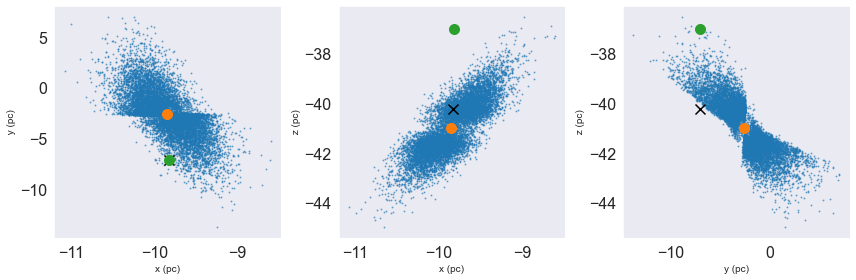

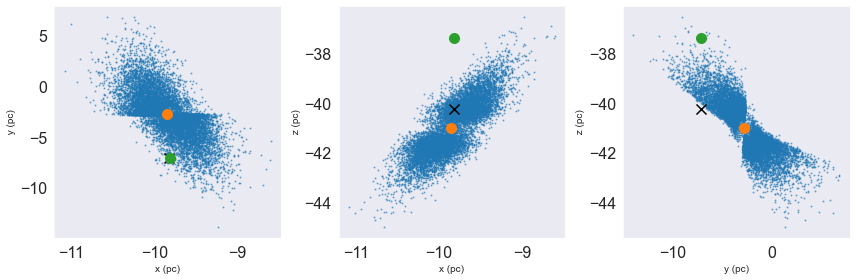

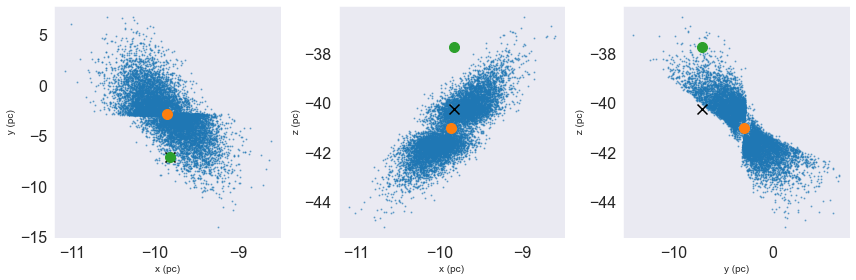

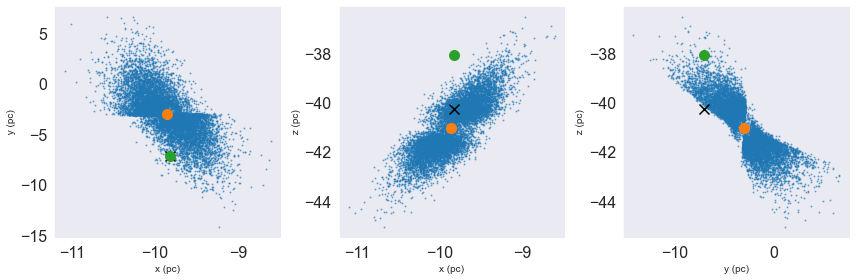

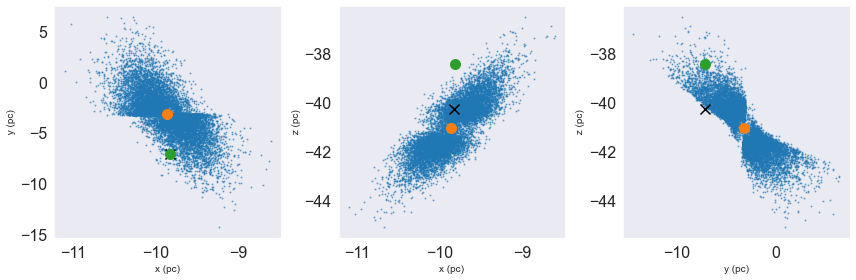

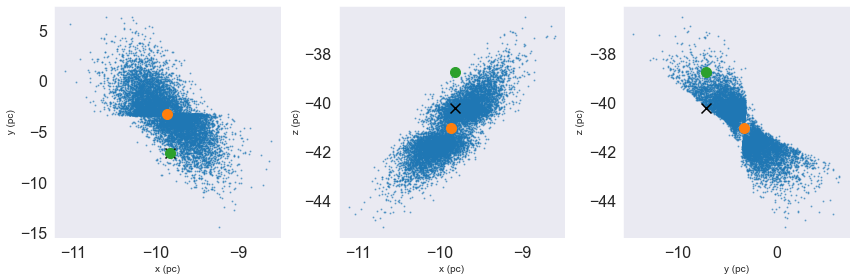

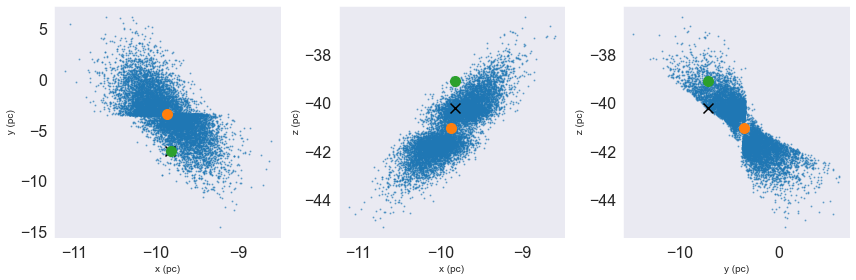

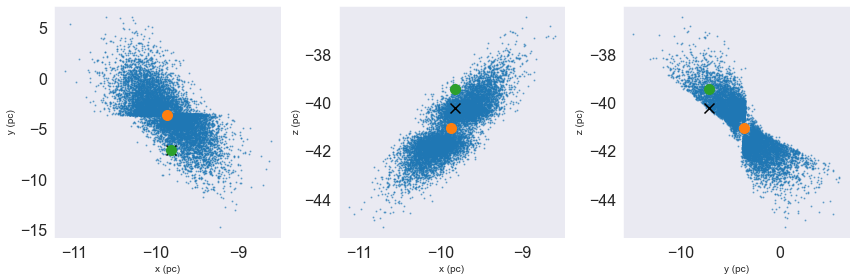

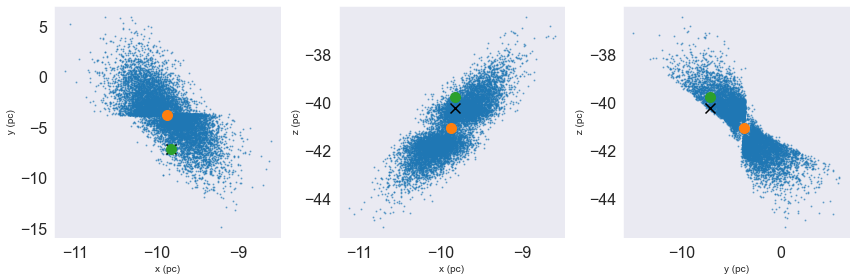

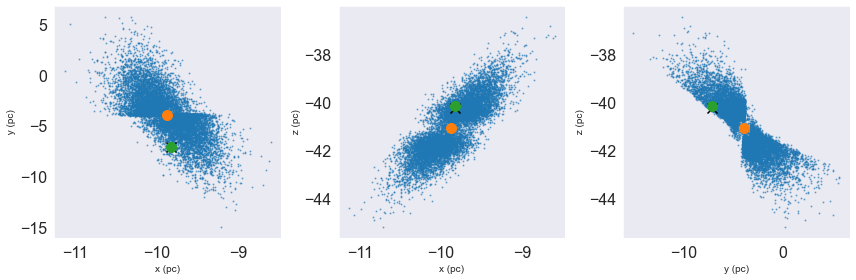

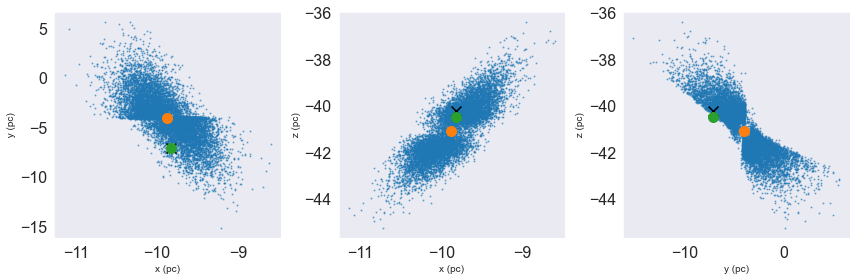

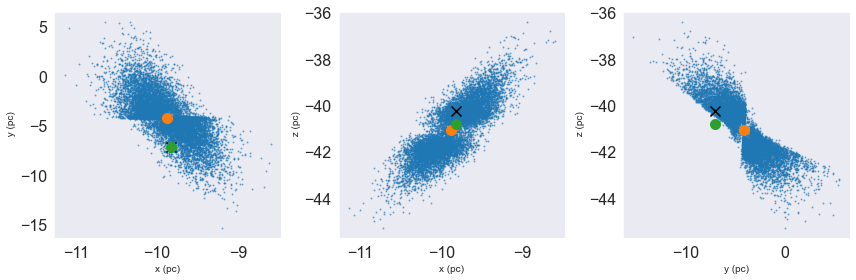

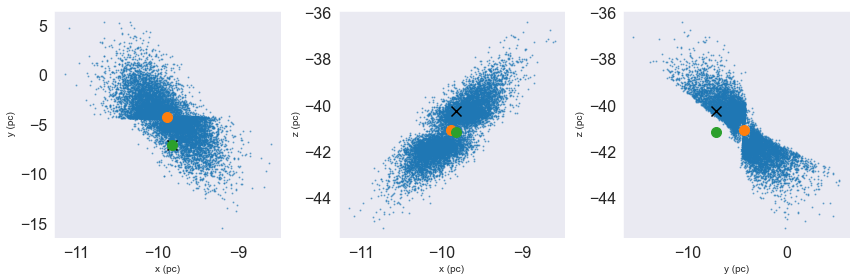

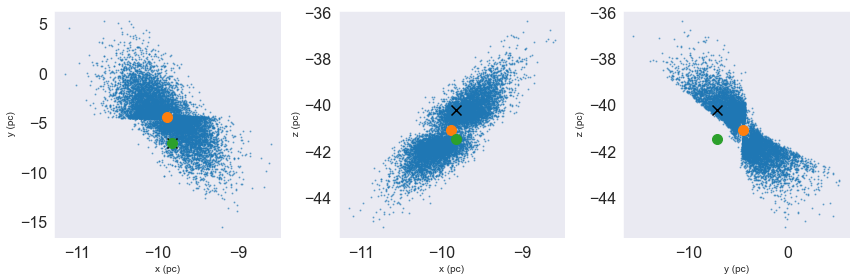

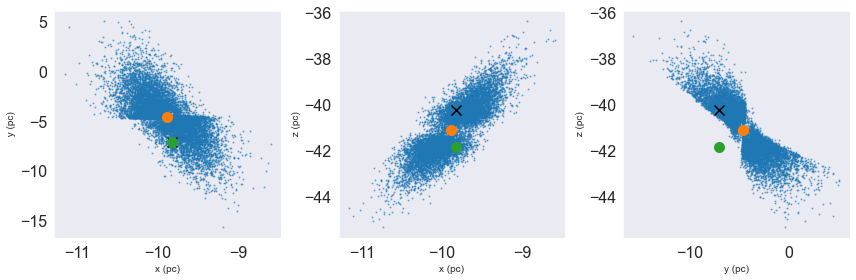

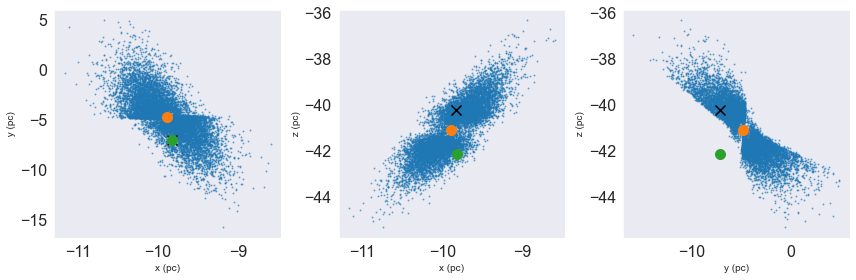

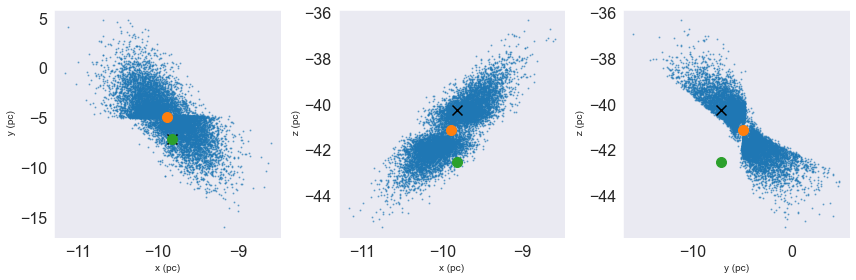

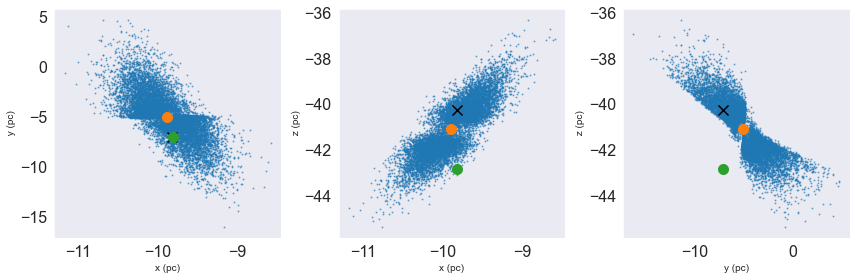

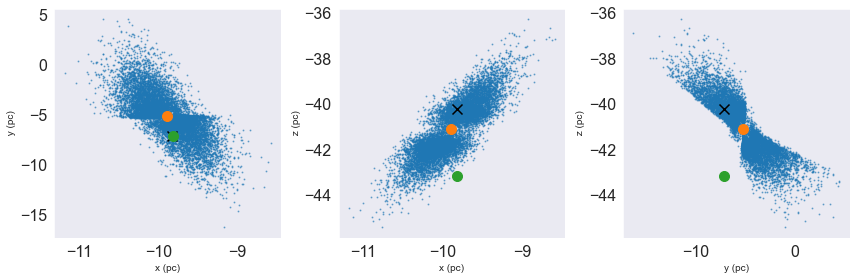

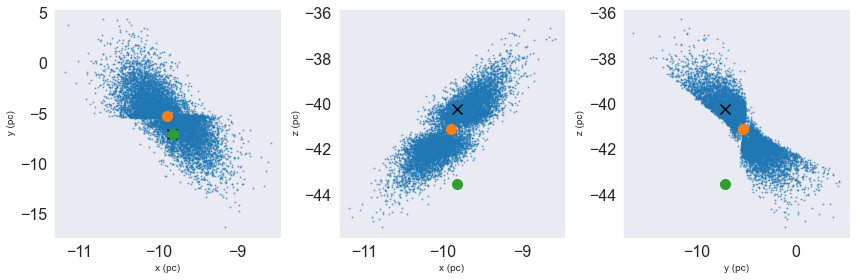

In [20]:
for s in steps:
    st_snapshot=stream_all['pos'][:, s, :]
    
    st_body, hl_body=(bdy_all['pos'][:, s, :]).T

    fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

    ax[0].scatter( st_snapshot[0], st_snapshot[1], s=1, alpha=0.5)
    ax[1].scatter( st_snapshot[0], st_snapshot[-1], s=1, alpha=0.5)
    ax[-1].scatter( st_snapshot[1], st_snapshot[-1], s=1, alpha=0.5)
    
    #ax[0].scater(st_body, )
    
    ax[0].scatter(collision_pos[0], collision_pos[1], marker='x', s=100, c='k')
    ax[1].scatter(collision_pos[0], collision_pos[-1], marker='x', s=100, c='k')
    ax[-1].scatter(collision_pos[1], collision_pos[-1], marker='x', s=100, c='k')
    
    for body in [st_body, hl_body]:
    
        ax[0].scatter(body[0], body[1], marker='o', s=100)
        ax[1].scatter(body[0], body[-1], marker='o', s=100)
        ax[-1].scatter(body[1], body[-1], marker='o', s=100)

    for a in ax:
        a.minorticks_on()

    ax[0].set( xlabel='x (pc)', ylabel=' y (pc)')
    ax[1].set( xlabel='x (pc)', ylabel=' z (pc)')
    ax[-1].set( xlabel='y (pc)', ylabel=' z (pc)')
    #cbar=plt.colorbar(c)
    plt.tight_layout()

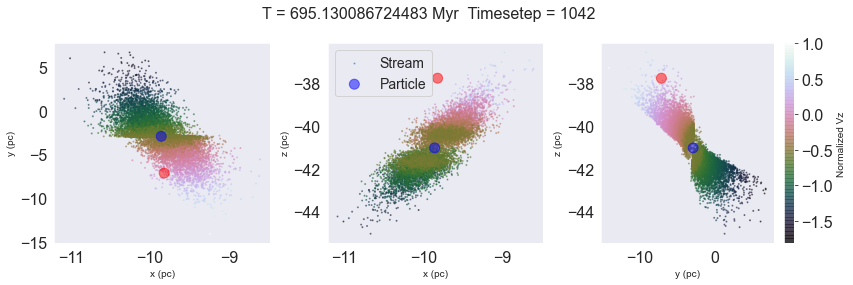

In [78]:
_= plot_stream_and_body(1042, stream_all, bdy_all,  time_dict)

In [85]:
#

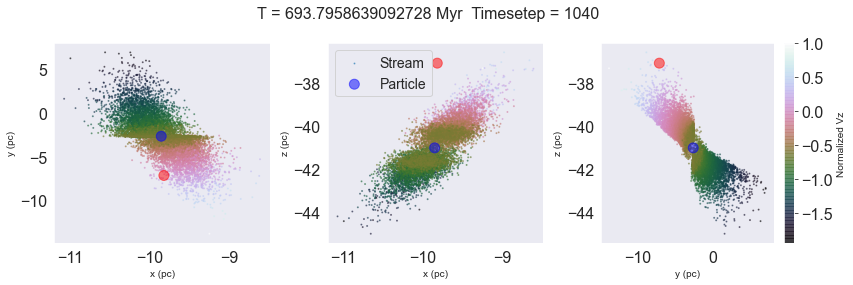

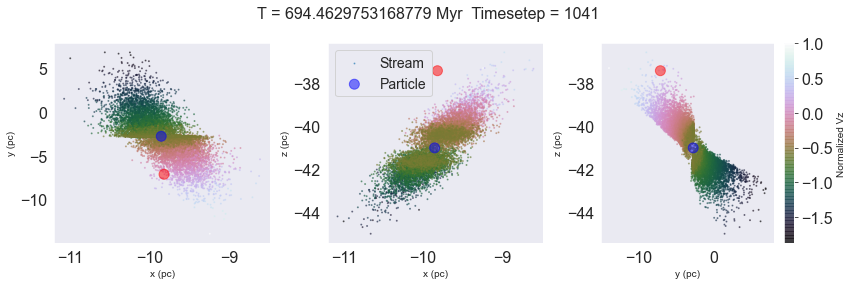

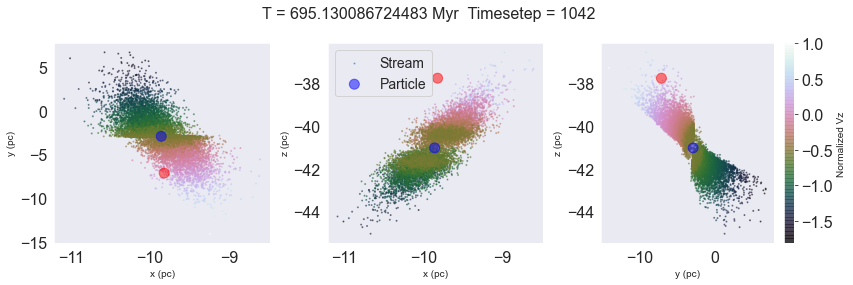

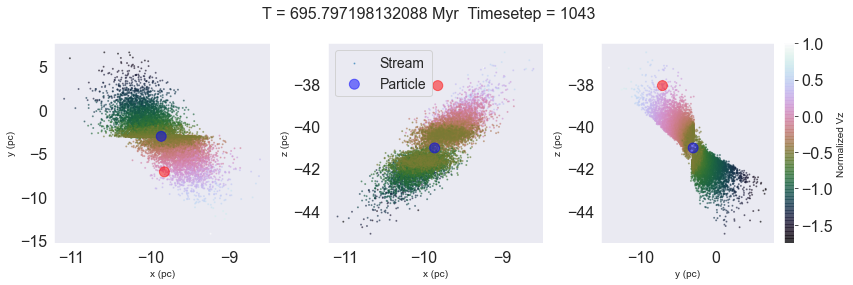

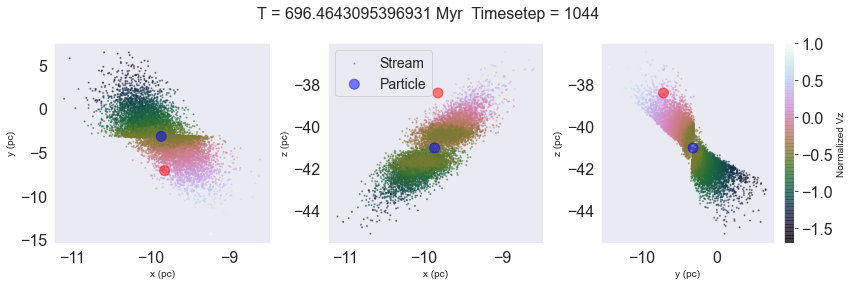

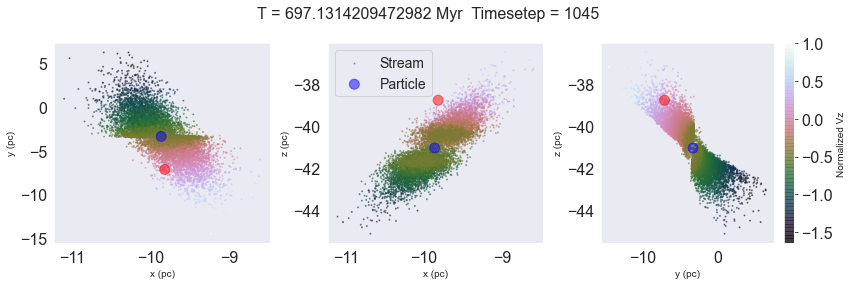

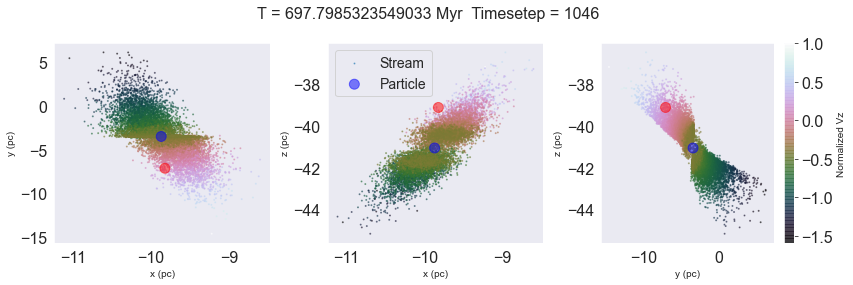

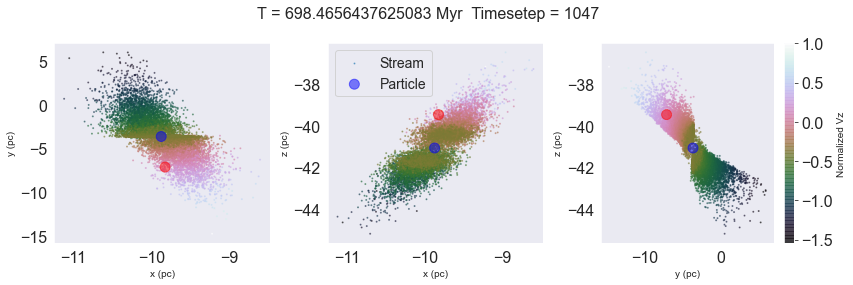

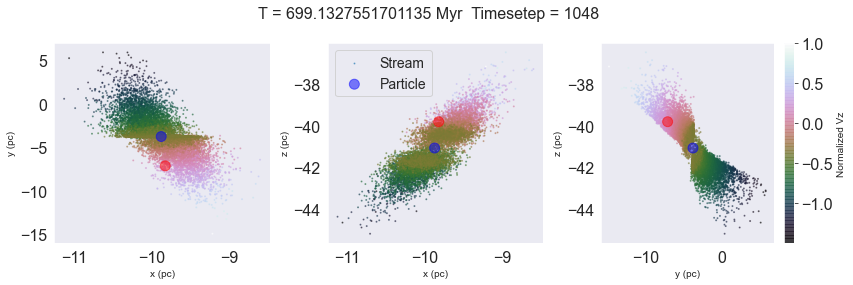

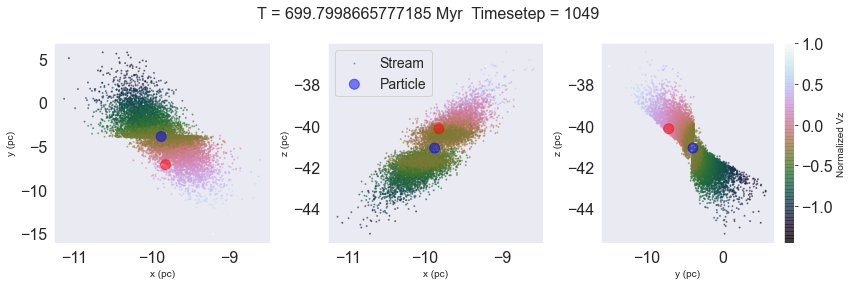

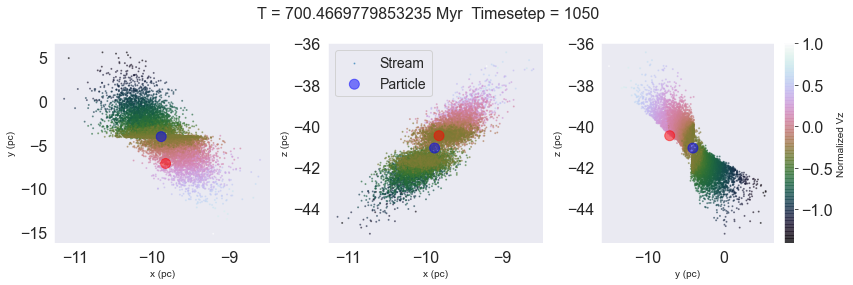

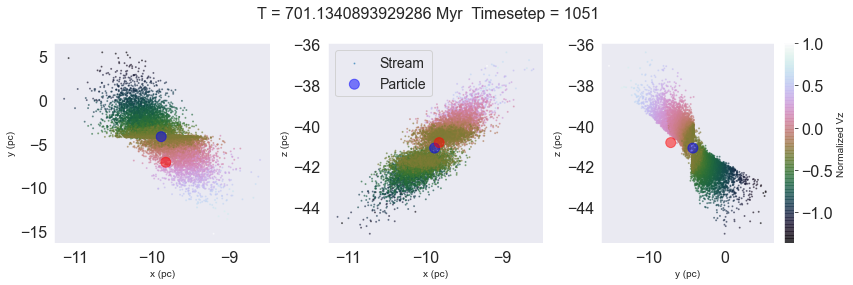

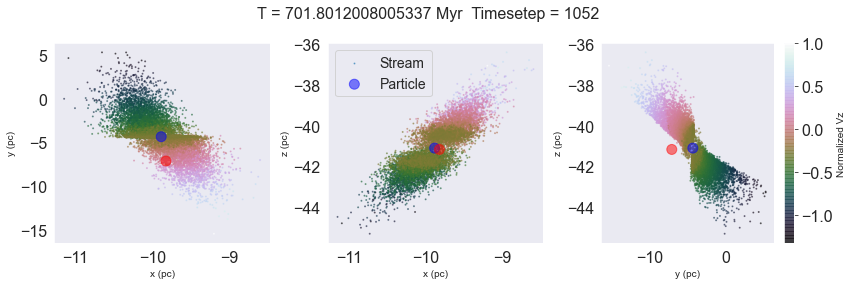

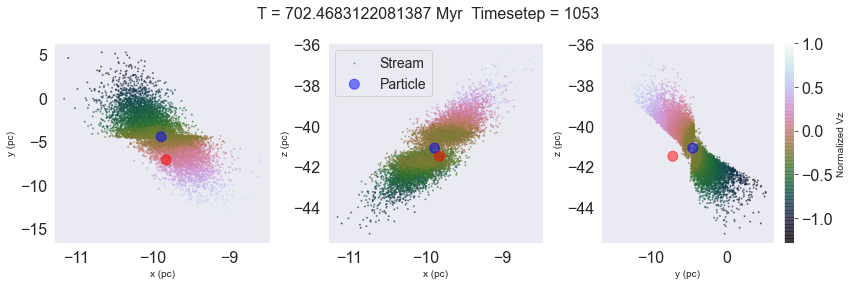

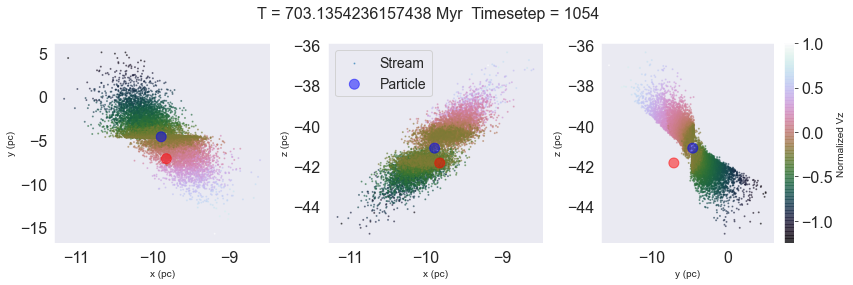

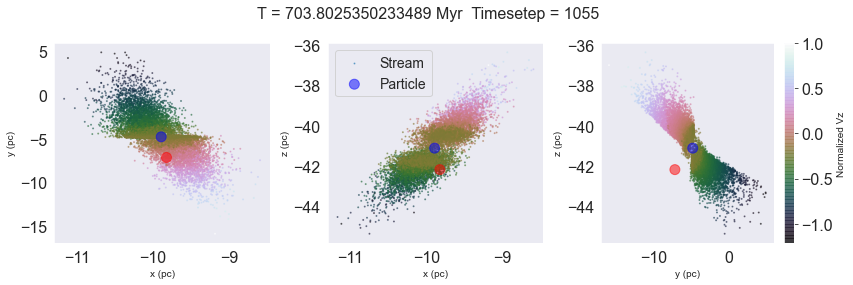

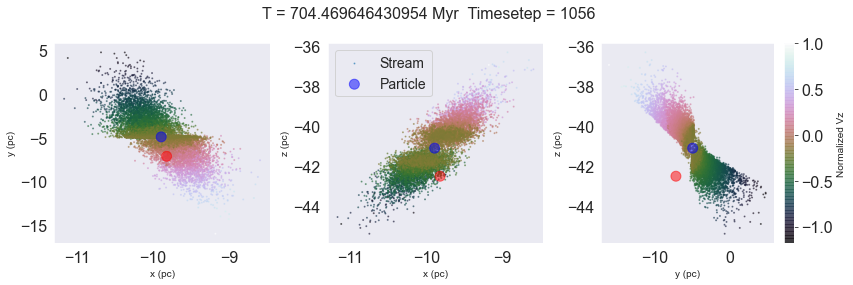

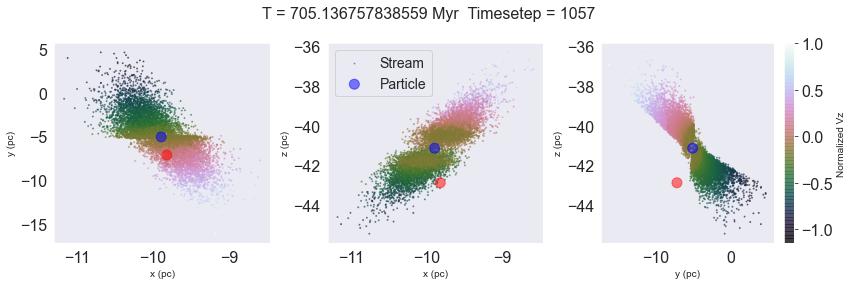

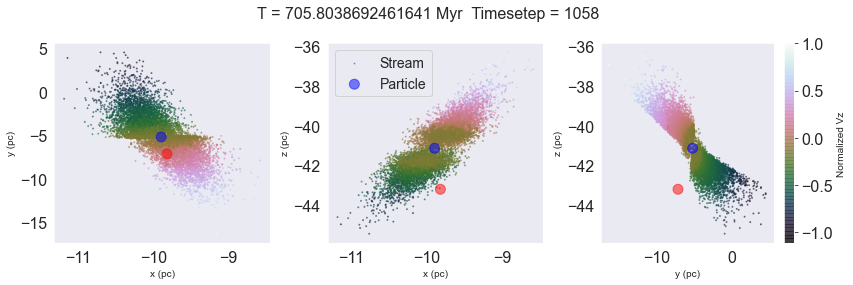

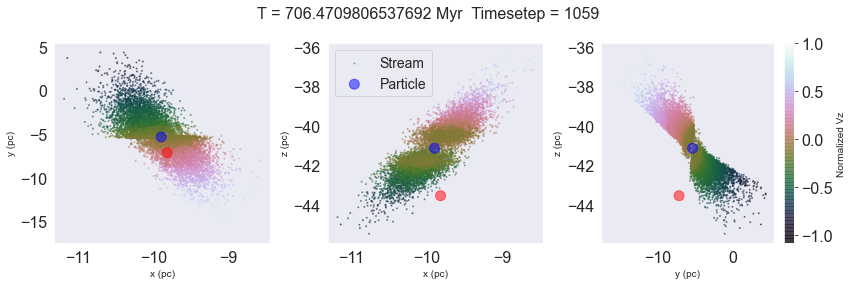

In [79]:
#double check the collision
#plot gifs to see if there as a collision
kwargs_write = {'fps':30.0, 'quantizer':'nq'}
_= imageio.mimsave(path_plot+'/'+ filename+'.gif',\
                   [ plot_stream_and_body(i, stream_all, bdy_all,  time_dict) for i in \
                                     steps], \
                   fps=10.0)

In [22]:
time_dict_total={'t':np.linspace(0, tfinal-tmax, int(nsteps*5))*u.Myr}

In [23]:
#integrate individual stars
final_col_stream_pos=gd.PhaseSpacePosition(pos=col_stream.xyz,
                                           vel=col_stream.v_xyz)
final_progen_pos=gd.PhaseSpacePosition(pos=col_pos.xyz,
                                           vel=col_pos.v_xyz)
final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(final_col_stream_pos,  **time_dict_total)
final_prog_orbit=gp.Hamiltonian(pot).integrate_orbit(final_progen_pos,  **time_dict_total)

In [24]:
final_stream_coord=SkyCoord(x=final_stream_orbit.x[-1], y=final_stream_orbit.y[-1],
                           z= final_stream_orbit.z[-1],frame='galactocentric')
final_prog_coord=SkyCoord(x=final_prog_orbit.x[-1], y=final_prog_orbit.y[-1],  \
                         z=final_prog_orbit.z[-1], frame='galactocentric')

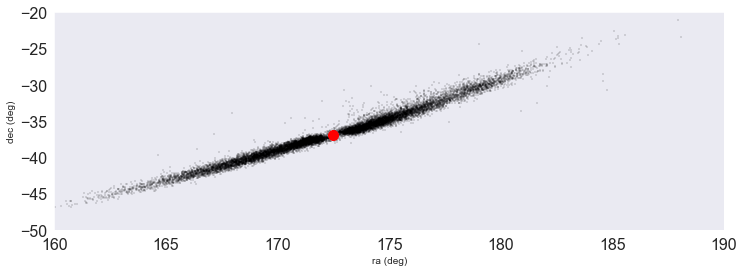

In [25]:
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(final_stream_coord.icrs.ra, final_stream_coord.icrs.dec, s=1, marker=',', c='k', alpha=0.1)
ax.scatter(final_prog_coord.icrs.ra[0], final_prog_coord.icrs.dec[0], s=100, marker='o', alpha=1, c='r')

ax.set(xlabel='ra (deg)', ylabel='dec (deg)', xlim=[160,190], ylim=[-50, -20])

ax.minorticks_on()

In [26]:
d={'stream': final_stream_coord, 'prog': final_prog_coord }

In [27]:
np.save(path_data+'/fav_andromeda_stream_mass{}.npy'.format(mhalo), d)

In [28]:
'/fav_andromeda_stream_mass{}.npy'.format(mhalo)

'/fav_andromeda_stream_mass100000000.0.npy'

In [29]:
time_dict_total_f={'t':np.linspace(0, tfinal, int(nsteps*5))*u.Myr}

In [30]:
#run stream by itself to see if the tails are still shimmered or messed up 
#time_dict= 
df = ms.FardalStreamDF()
prog_mass = mstream* u.Msun
gen = ms.MockStreamGenerator(df, H)
mock_st, mock_pos=gen.run(st_pos, prog_mass, **time_dict_total_f, nbody=None, n_particles=1, progress=True)

Integrating orbits:  100%

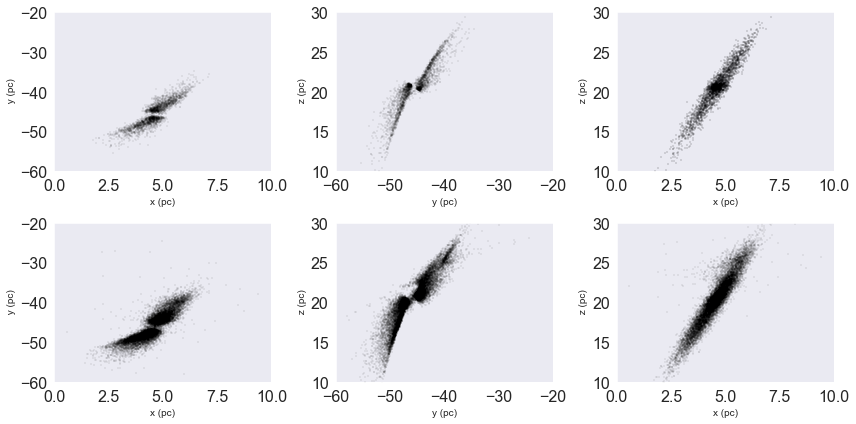

In [31]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
ax[0][0].scatter(mock_st.cartesian.x, mock_st.cartesian.y,  s=1, alpha=0.05, c='k', marker=',')
ax[0][1].scatter(mock_st.cartesian.y, mock_st.cartesian.z,  s=1, alpha=0.05, c='k', marker=',')
ax[0][2].scatter(mock_st.cartesian.x, mock_st.cartesian.z,  s=1, alpha=0.1, c='k', marker=',')


ax[1][0].scatter(final_stream_orbit.x[-1], final_stream_orbit.y[-1],  s=1, alpha=0.05, c='k', marker=',')
ax[1][1].scatter(final_stream_orbit.y[-1], final_stream_orbit.z[-1], s=1, alpha=0.05, c='k', marker=',')
ax[1][2].scatter(final_stream_orbit.x[-1], final_stream_orbit.z[-1], s=1, alpha=0.05, c='k', marker=',')

for a in ax:
#    a[0].scatter(final_prog_orbit[-1].x[0], final_prog_orbit[-1].y[0],  s=100, c='b')
#    a[1].scatter(final_prog_orbit[-1].y[0], final_prog_orbit[-1].z[0],  s=100, c='b')
#    a[-1].scatter(final_prog_orbit[-1].x[0], final_prog_orbit[-1].z[0],  s=100, c='b')
    
    xlim=[0, 10]
    ylim=[-60, -20]
    zlim=[10, 30]

    a[0].set( xlabel='x (pc)', ylabel=' y (pc)', xlim=xlim, ylim=ylim)
    a[1].set( xlabel='y (pc)', ylabel=' z (pc)', xlim=ylim, ylim=zlim)
    a[-1].set( xlabel='x (pc)', ylabel=' z (pc)', xlim=xlim, ylim=zlim)


plt.tight_layout()


plt.savefig(path_plot +'/50kpc_stream_combined.jpeg')

In [32]:
path_plot

'/users/caganze/research/stellarstreams/figures/streamssims/'

In [47]:
#_=final_stream_orbit[].plot()

In [83]:
mock_st.v_xyz

<Quantity [[0.03745663, 0.0342528 , 0.03819582, ..., 0.03534883,
            0.03766422, 0.03632391],
           [0.0705856 , 0.10681257, 0.06999992, ..., 0.09082809,
            0.09271888, 0.09095991],
           [0.15890963, 0.14250921, 0.15986744, ..., 0.14932009,
            0.15303752, 0.14943221]] kpc / Myr>